In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import coffea.util as util
import time
import json
import os
import copy
from hist import Hist
sys.path.append("../../analysisTools/")
import plotTools as ptools
import utils
import mplhep as hep
import utils
hep.style.use("CMS")
plt.rcParams['font.size'] = 16.0
from matplotlib.colors import Normalize, LogNorm
from copy import deepcopy
from tqdm import tqdm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
class histContainer:
    def __init__(self,path,noMeta=False,bkg=False):
        if noMeta:
            self.histos, self.metadata = util.load(path), None
        else:
            self.histos, self.metadata = util.load(path)
        self.hnames = list(self.histos.keys())
        if bkg:
            self.catSamps,self.catNames = utils.bkg_categories(self.histos['cutflow'])
            self.cats = list(self.catSamps.keys())
    def load(self,hname):
        return self.histos[hname]
    def load(self,hname):
        return self.histos[hname]
    def names(self,spec=None):
        if spec is not None:
            print("\n".join([h for h in self.hnames if spec in h]))
        else:
            print("\n".join(self.hnames))
            
def getPresentSamples(h,possibleSamples):
    for a in h.axes:
        if a.name=='samp':
            ax = a
            break
    nbins = len(ax.centers)
    avail = [ax.bin(i) for i in range(nbins)]
    return [p for p in possibleSamples if p in avail]

def make_label(row):
    m1 = int(row['m1'])
    delta = int(100*row['delta'])
    ct = int(row['ctau'])
    label = f"{delta}%, {m1} GeV, {ct} mm"
    return label

In [3]:
def plot_samples_sigBkg(loader_sig,loader_bkg,hname,selection,samples,labels,outName,outD,
                 xlabel=None,ylabel=None,title=None,xlim=None,ylim=None,
                 ncol_leg=1,figsize=None,logy=False,logx=False,rebin=1j,
                 save=True,show=False,density=False,yerr=True,histtype='errorbar',legend_loc='best'):
    if not figsize:
        figsize=(8,6)
    plt.figure(figsize=figsize)
    # load signal histograms
    h_sig = loader_sig.load(hname)[selection]
    histos_sig = [h_sig[{"samp":s}][::rebin] for s in samples]
    labels_sig = labels
    # load bkg histograms
    h_bkg = loader_bkg.load(hname)[selection]
    labels_bkg = loader_bkg.cats
    histos_bkg = []
    colors_bkg = []
    for cat in labels_bkg:
        trueSel = getPresentSamples(h_bkg,loader_bkg.catSamps[cat])
        histos_bkg.append(h_bkg[{"samp":trueSel}][{"samp":sum}][::rebin])
        colors_bkg.append(ptools.bkg_cmap[cat])
    # plot histograms
    colors_sig = ['k','g','b','c']
    hep.histplot(histos_bkg,label=labels_bkg,density=density,yerr=yerr,stack=True,histtype='fill',color=colors_bkg)
    hep.histplot(histos_sig,label=labels_sig,density=density,yerr=yerr,color=colors_sig,histtype=histtype,lw=2)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        if density:
            plt.ylabel("A.U.")
        else:
            plt.ylabel("Events")
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    plt.legend(ncol=ncol_leg,fontsize=12,loc=legend_loc)
    #hep.cms.label("Simulation", data=False, year=2018)
    plt.tight_layout()
    if save:
        os.makedirs(outD,exist_ok=True)
        if density:
            plt.savefig(f"{outD}/{outName}_density.pdf")
        else:
            plt.savefig(f"{outD}/{outName}.pdf")
    if not show:
        plt.close()

In [4]:
def plot_samples_bkgOnly(loader_sig,loader_bkg,hname,selection,outName,outD,
                 xlabel=None,ylabel=None,title=None,xlim=None,ylim=None,
                 ncol_leg=1,figsize=None,logy=False,logx=False,rebin=1j,
                 save=True,show=False,density=False,yerr=True,histtype='errorbar',legend_loc='best'):
    if not figsize:
        figsize=(8,6)
    plt.figure(figsize=figsize)
    # load bkg histograms
    h_bkg = loader_bkg.load(hname)[selection]
    labels_bkg = loader_bkg.cats
    histos_bkg = []
    colors_bkg = []
    for cat in labels_bkg:
        trueSel = getPresentSamples(h_bkg,loader_bkg.catSamps[cat])
        histos_bkg.append(h_bkg[{"samp":trueSel}][{"samp":sum}][::rebin])
        colors_bkg.append(ptools.bkg_cmap[cat])
    # plot histograms
    hep.histplot(histos_bkg,label=labels_bkg,density=density,yerr=yerr,stack=True,histtype='fill',color=colors_bkg)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        if density:
            plt.ylabel("A.U.")
        else:
            plt.ylabel("Events")
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    plt.legend(ncol=ncol_leg,fontsize=12,loc=legend_loc)
    #hep.cms.label("Simulation", data=False, year=2018)
    plt.tight_layout()
    if save:
        os.makedirs(outD,exist_ok=True)
        if density:
            plt.savefig(f"{outD}/{outName}_density.pdf")
        else:
            plt.savefig(f"{outD}/{outName}.pdf")
    if not show:
        plt.close()

In [5]:
from matplotlib.lines import Line2D
def make_cdf_summary_sigVsBkg(dfs,loader_sig,loader_bkg,hname_sig,hname_bkg,selection,outName,outD,right=True,
                 xlabel=None,ylabel=None,title=None,xlim=None,ylim=None,
                 ncol_leg=1,figsize=None,logy=False,logx=False,alpha=1,
                 save=True,show=False,legend_loc='best',category=False):
    if not figsize:
        figsize=(8,6)
    #fig,axes = plt.subplots(2,1,figsize=figsize,height_ratios=[3,1],sharex=True)
    fig,axes = plt.subplots(1,1,figsize=figsize)
    hsig = loader_sig.load(hname_sig)[selection]
    hbkg = loader_bkg.load(hname_bkg)[selection]
    for s in dfs.name:
        hsamp = hsig[{"samp":s}]
        if xlim:
            edges = xlim
        else:
            edges = hsamp.axes[0].edges[:-1] if right else hsamp.axes[0].edges[1:]
        x,eff_real = ptools.makeCDF(hsamp,edges[0],edges[-1],right=right,category=category)
        plt.plot(x,eff_real,color='green',alpha=0.5,lw=2)
    handles = [Line2D([],[],lw=2,color='green',label="Signals")]
    for bkg_cat in loader_bkg.cats:
        trueSel = getPresentSamples(hbkg,loader_bkg.catSamps[bkg_cat])
        hsamp = hbkg[{"samp":trueSel}][{"samp":sum}]
        x,eff_fake = ptools.makeCDF(hsamp,edges[0],edges[-1],right=right,category=category)
        h, = plt.plot(x,eff_fake,alpha=1,lw=2,label=bkg_cat,color=ptools.bkg_cmap[bkg_cat])
        handles.append(h)
    plt.legend(handles=handles,loc=legend_loc,ncol=ncol_leg)
    if xlabel:
        plt.xlabel(xlabel)
    if right:
        plt.ylabel("Cumulative Distribution (Right)")
    else:
        plt.ylabel("Cumulative Distribution (Left)")
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    plt.grid()
    plt.tight_layout()
    if save:
        os.makedirs(outD,exist_ok=True)
        plt.savefig(f"{outD}/{outName}.pdf")
    if not show:
        plt.close()

In [6]:
from matplotlib.lines import Line2D
def make_Nminus1_sigVsBkg(dfs,loader_sig,loader_bkg,hname_sig,hname_bkg,selection,outName,outD,right=True,
                 xlabel=None,ylabel=None,title=None,xlim=None,ylim=None,
                 ncol_leg=1,figsize=None,logy=False,logx=False,alpha=1,
                 save=True,show=False,legend_loc='best',category=False):
    if not figsize:
        figsize=(8,6)
    #fig,axes = plt.subplots(2,1,figsize=figsize,height_ratios=[3,1],sharex=True)
    fig,axes = plt.subplots(1,1,figsize=figsize)
    hsig = loader_sig.load(hname_sig)[selection]
    hbkg = loader_bkg.load(hname_bkg)[selection]
    
    # get bkg yields as a function of cut
    bkg_yields = []
    for bkg_cat in loader_bkg.cats:
        trueSel = getPresentSamples(hbkg,loader_bkg.catSamps[bkg_cat])
        hsamp = hbkg[{"samp":trueSel}][{"samp":sum}]
        if xlim:
            edges = xlim
        else:
            edges = hsamp.axes[0].edges[:-1] if right else hsamp.axes[0].edges[1:]
        x,nbkg = ptools.makeCDF(hsamp,edges[0],edges[-1],right=right,category=category,nevents=True)
        bkg_yields.append(nbkg)
    tot_bkg = sum(bkg_yields)
    
    for s in dfs.name:
        hsamp = hsig[{"samp":s}]
        if xlim:
            edges = xlim
        else:
            edges = hsamp.axes[0].edges[:-1] if right else hsamp.axes[0].edges[1:]
        x,sig_yields = ptools.makeCDF(hsamp,edges[0],edges[-1],right=right,category=category,nevents=True)
        plt.plot(x,sig_yields/tot_bkg,color='green',alpha=0.5,lw=2)
        
    handles = [Line2D([],[],lw=2,color='green',label="Signals")]
    plt.legend(handles=handles,loc=legend_loc,ncol=ncol_leg)
    if xlabel:
        plt.xlabel(xlabel)
    if right:
        plt.ylabel(r"$S/\sqrt{B}$ (Right)")
    else:
        plt.ylabel(r"$S/\sqrt{B}$ (Left)")
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    plt.grid()
    plt.tight_layout()
    if save:
        os.makedirs(outD,exist_ok=True)
        plt.savefig(f"{outD}/{outName}.pdf")
    if not show:
        plt.close()

In [7]:
hcs = histContainer("skimmed_signal_MET170_histos_cuts.coffea")
hcb = histContainer("skimmed_bkg_MET170_histos_cuts.coffea",bkg=True)
dfs = utils.get_dict_fromCutflow(hcs.load('cutflow'))
dfs['legend'] = dfs.apply(make_label,axis=1)
selected_signals = ["sig_2018_Mchi-10p5_dMchi-1p0_ctau-1",
                    "sig_2018_Mchi-11p0_dMchi-2p0_ctau-100",
                    "sig_2018_Mchi-52p5_dMchi-5p0_ctau-10",
                    "sig_2018_Mchi-77p0_dMchi-14p0_ctau-100"]
selected_labels = [dfs[dfs.name==s].legend.item() for s in selected_signals]

# Plots

In [8]:
cuts = ['cut4']
cutDesc = hcs.load('cutDesc')

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


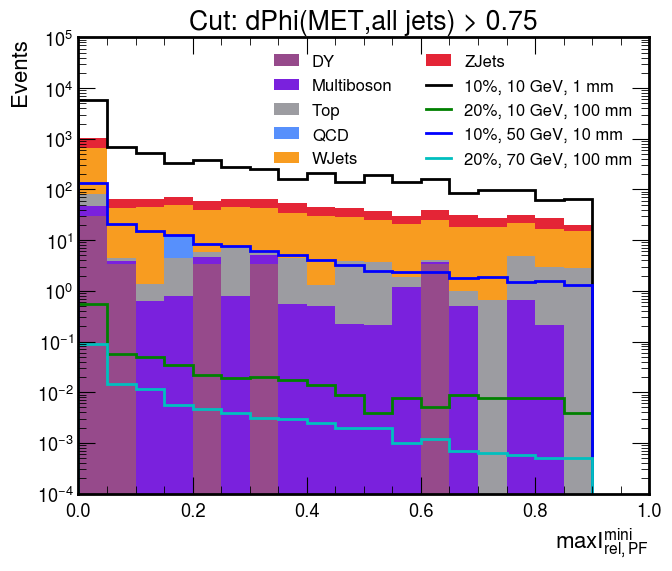

In [10]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_maxMiniRelIsoEleCorr_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = "$\max I_{rel,PF}^{mini}$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_maxMiniRelIsoCorr",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),xlim=[0,1],ylim=[1e-4,1e5],ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


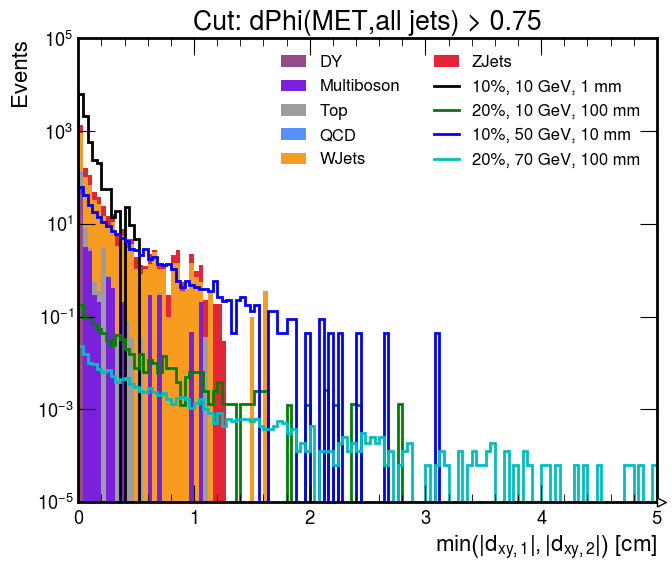

In [11]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_minDxy_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$\min\left(|d_{xy,1}|,|d_{xy,2}|\right)$ [cm]"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_mindxy",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),xlim=[0,5],ylim=[1e-5,1e5],ncol_leg=2,xlabel=xlabel,rebin=4j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:199: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


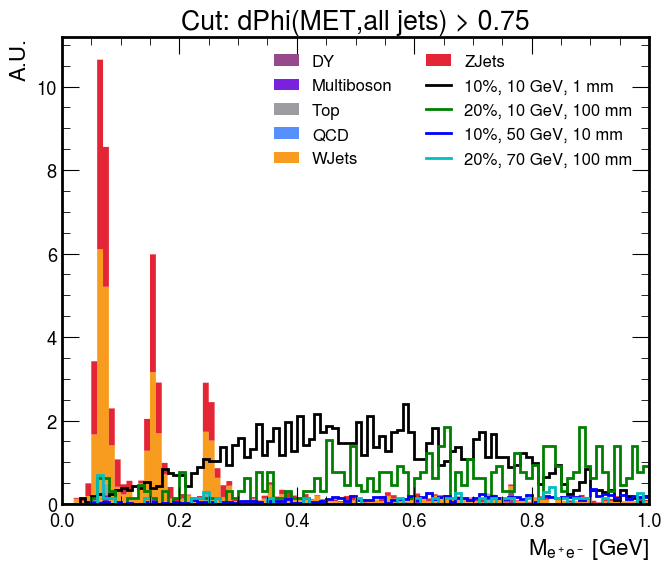

In [13]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_mass_low_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$M_{e^+e^-}$ [GeV]"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_mass_low",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),xlim=[0,1],ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=False,density=True,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


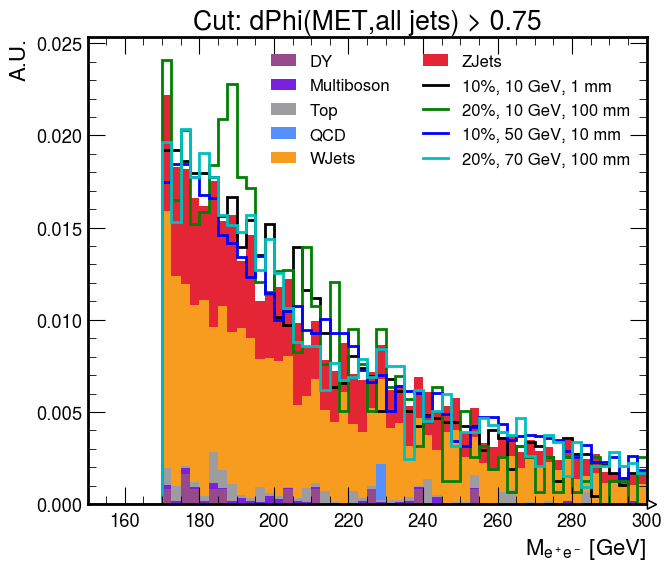

In [17]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "PFMET"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$M_{e^+e^-}$ [GeV]"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"PFMET",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),xlim=[150,300],ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=False,density=True,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


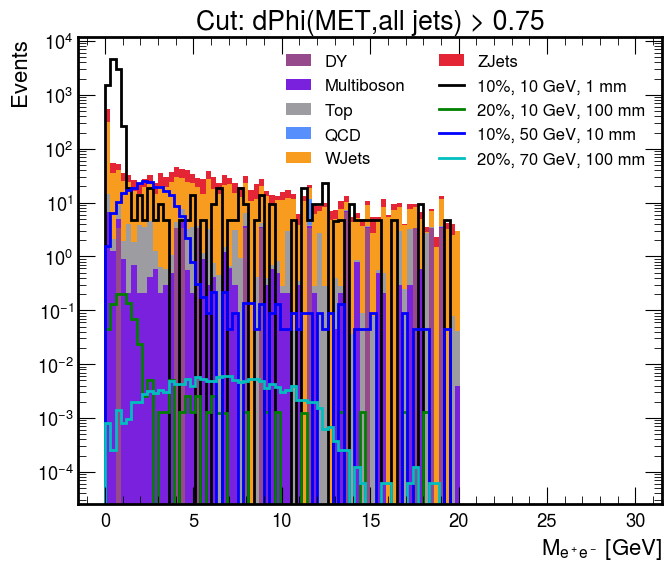

In [21]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_mass_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$M_{e^+e^-}$ [GeV]"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_mass",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

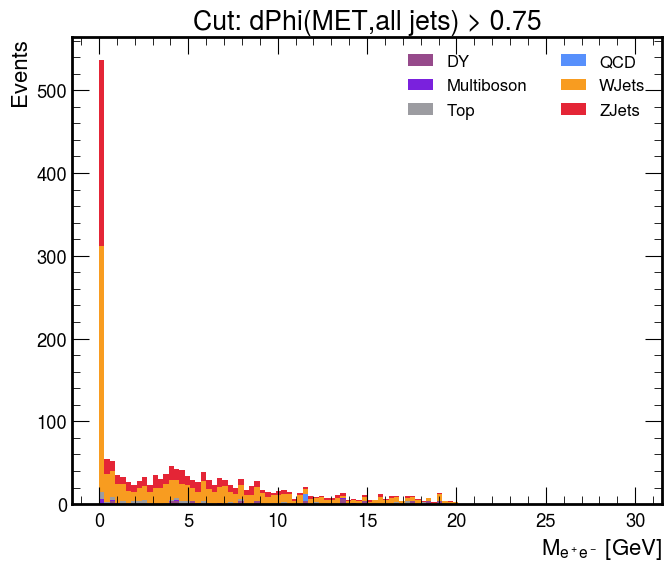

In [26]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_mass_bkgOnly"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$M_{e^+e^-}$ [GeV]"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_bkgOnly(hcs,hcb,"sel_vtx_mass",selection,outName,outD,
                 figsize=(7,6),ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=False,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


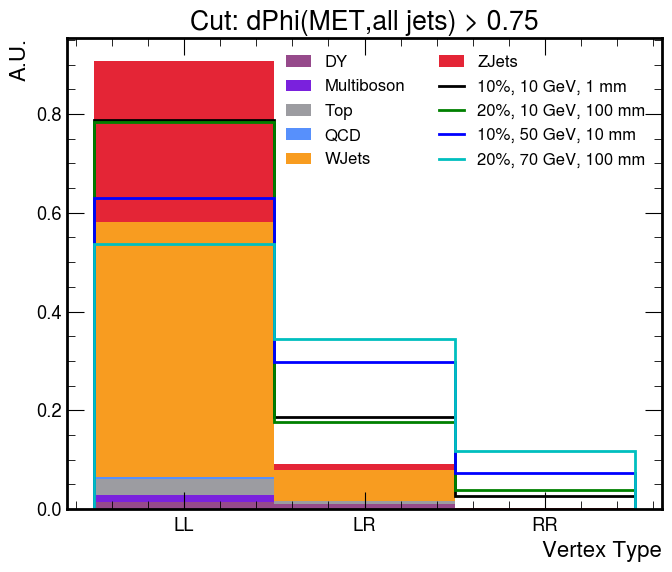

In [29]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_type_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"Vertex Type"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_type",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=False,density=True,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


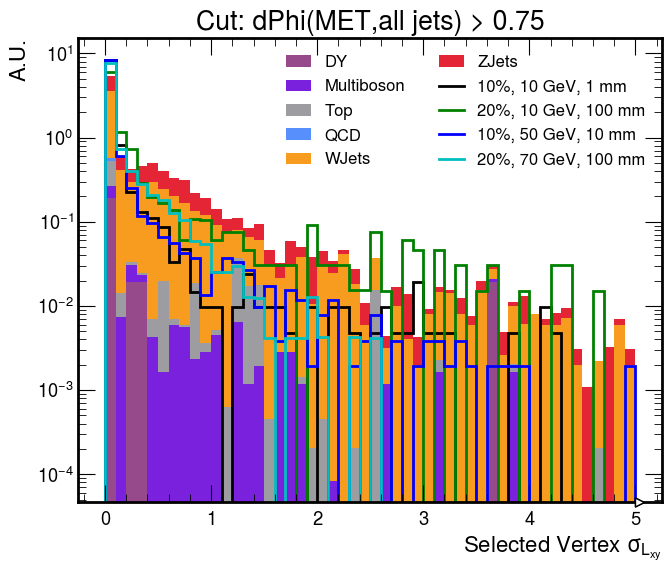

In [30]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_vxyRes_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"Selected Vertex $\sigma_{L_{xy}}$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_vxyRes",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ncol_leg=2,xlabel=xlabel,rebin=2j,
                        save=False,show=True,logy=True,density=True,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


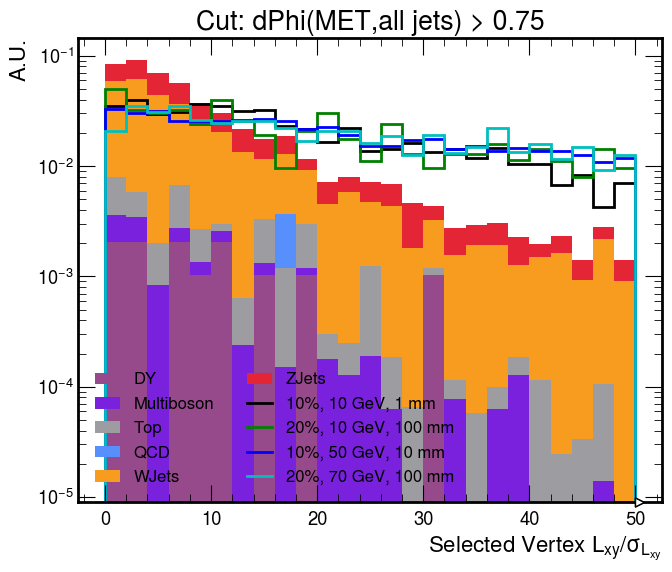

In [32]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_vxySignif_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"Selected Vertex $L_{xy}/\sigma_{L_{xy}}$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_vxySignif",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ncol_leg=2,xlabel=xlabel,rebin=20j,
                        save=False,show=True,logy=True,density=True,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


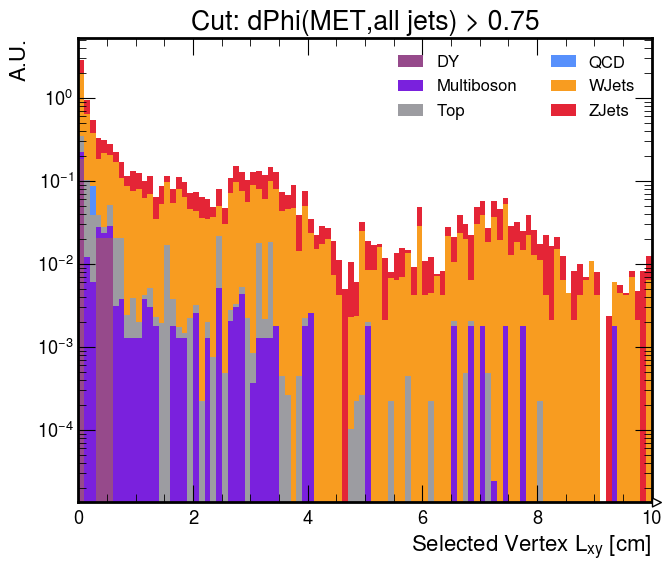

In [33]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_vxy10_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"Selected Vertex $L_{xy}$ [cm]"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_bkgOnly(hcs,hcb,"sel_vtx_vxy10",selection,outName,outD,
                 figsize=(7,6),xlim=[0,10],ncol_leg=2,xlabel=xlabel,rebin=1j,
                        save=False,show=True,logy=True,density=True,title=title,histtype='step',yerr=False)

(0.0, 1.0)

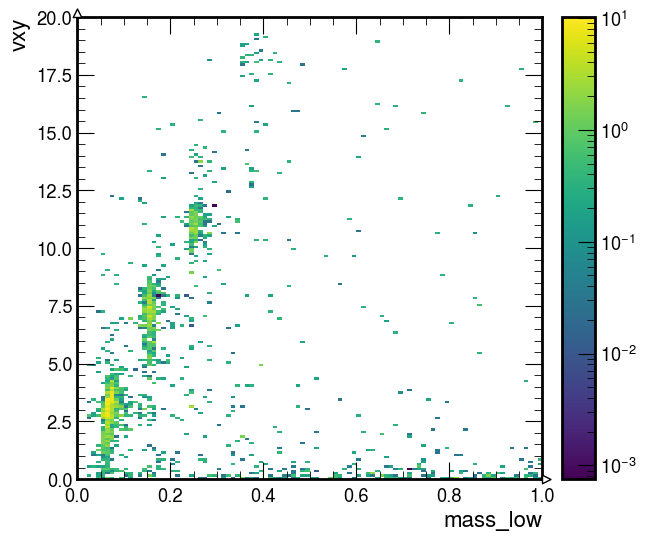

In [34]:
plt.figure(figsize=(6,6))
h = hcb.load("sel_vtx_mass_vs_vxy20")[{"samp":sum,"cut":"cut4"}]
hep.hist2dplot(h,norm=LogNorm())
plt.xlim([0,1])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7ff59261f250>, cbar=<matplotlib.colorbar.Colorbar object at 0x7ff58dccd8e0>, text=[])

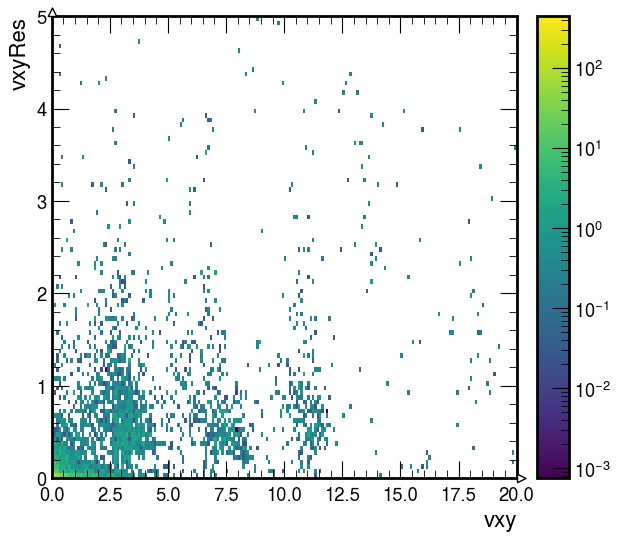

In [35]:
plt.figure(figsize=(6,6))
h = hcb.load("sel_vtx_vxy20_vs_vxyRes")[{"samp":sum,"cut":"cut4"}]
hep.hist2dplot(h,norm=LogNorm())
#plt.xlim([0,1])

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7ff58f63f6a0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7ff58dbe9ac0>, text=[])

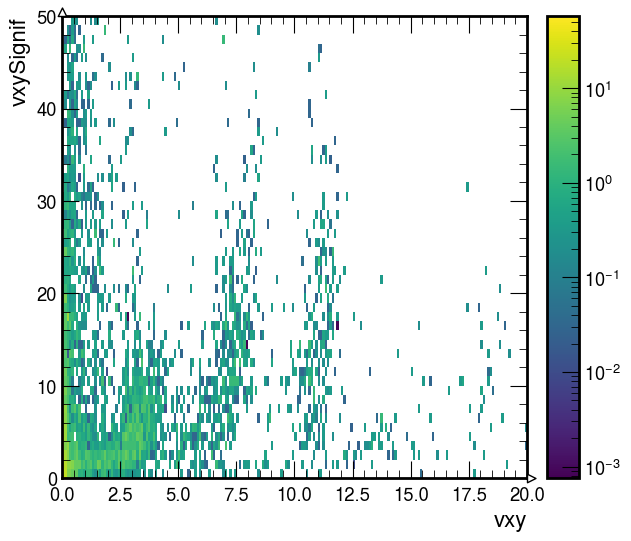

In [36]:
plt.figure(figsize=(6,6))
h = hcb.load("sel_vtx_vxy20_vs_vxySignif")[{"samp":sum,"cut":"cut4"}][:,::10j]
hep.hist2dplot(h,norm=LogNorm())
#plt.xlim([0,1])

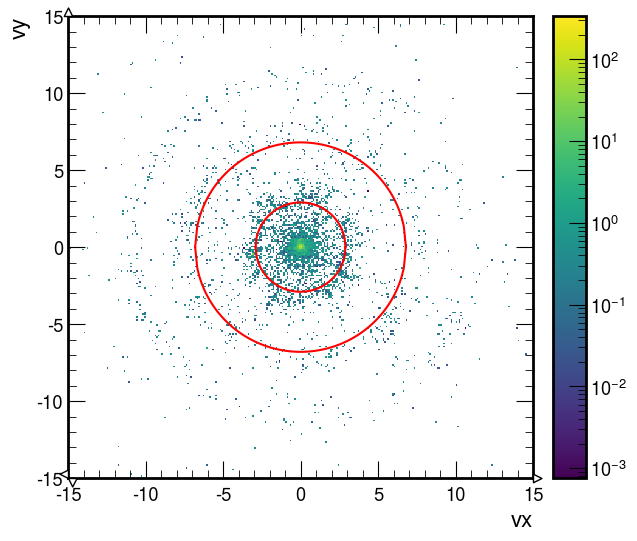

In [37]:
plt.figure(figsize=(6,6))
h = hcb.load("sel_vtx_vx_vs_vy")[{"samp":sum,"cut":"cut0"}][:,::1j]
hep.hist2dplot(h,norm=LogNorm())
#plt.xlim([0,1])

x3 = np.linspace(-2.9,2.9,100)
plt.plot(x3,np.sqrt(2.9**2 - x3**2),color='r')
plt.plot(x3,-np.sqrt(2.9**2 - x3**2),color='r')

x7 = np.linspace(-6.8,6.8,100)
plt.plot(x7,np.sqrt(6.8**2 - x7**2),color='r')
plt.plot(x7,-np.sqrt(6.8**2 - x7**2),color='r')

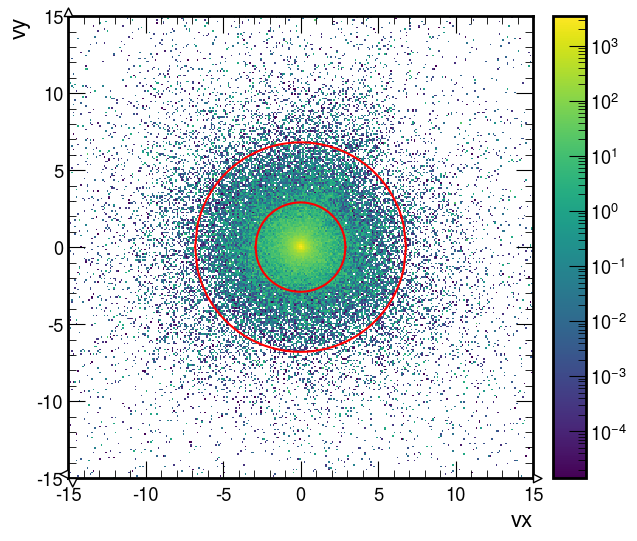

In [38]:
plt.figure(figsize=(6,6))
h = hcs.load("sel_vtx_vx_vs_vy")[{"samp":sum,"cut":"cut0"}][:,::1j]
hep.hist2dplot(h,norm=LogNorm())
#plt.xlim([0,1])

x3 = np.linspace(-2.9,2.9,100)
plt.plot(x3,np.sqrt(2.9**2 - x3**2),color='r')
plt.plot(x3,-np.sqrt(2.9**2 - x3**2),color='r')

x7 = np.linspace(-6.8,6.8,100)
plt.plot(x7,np.sqrt(6.8**2 - x7**2),color='r')
plt.plot(x7,-np.sqrt(6.8**2 - x7**2),color='r')

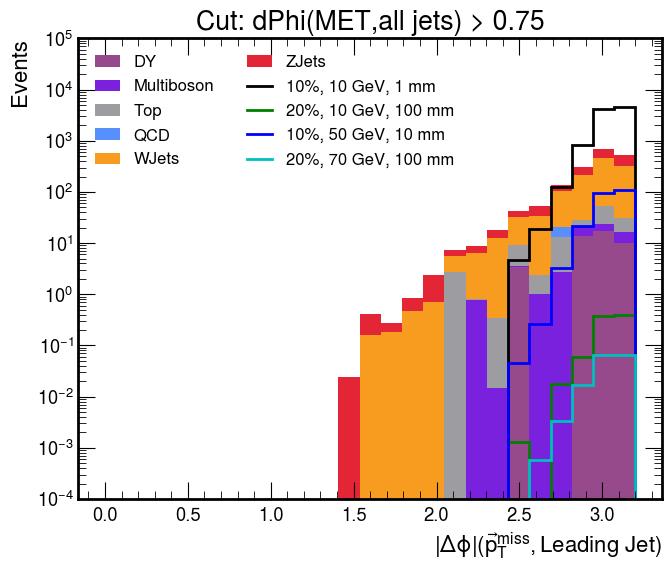

In [39]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "jetMETdPhi_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$|\Delta\phi|(\vec{p}_T^\mathrm{miss},\text{Leading Jet})$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"jetMETdPhi",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ylim=[1e-4,1e5],ncol_leg=2,xlabel=xlabel,rebin=4j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


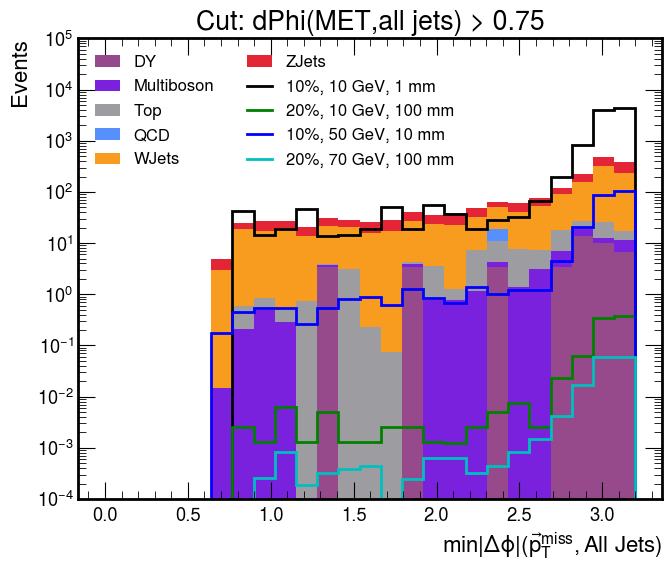

In [41]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "minJetMETdPhi_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$\min |\Delta\phi|(\vec{p}_T^\mathrm{miss},\text{All Jets})$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"minJetMETdPhi",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ylim=[1e-4,1e5],ncol_leg=2,xlabel=xlabel,rebin=4j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


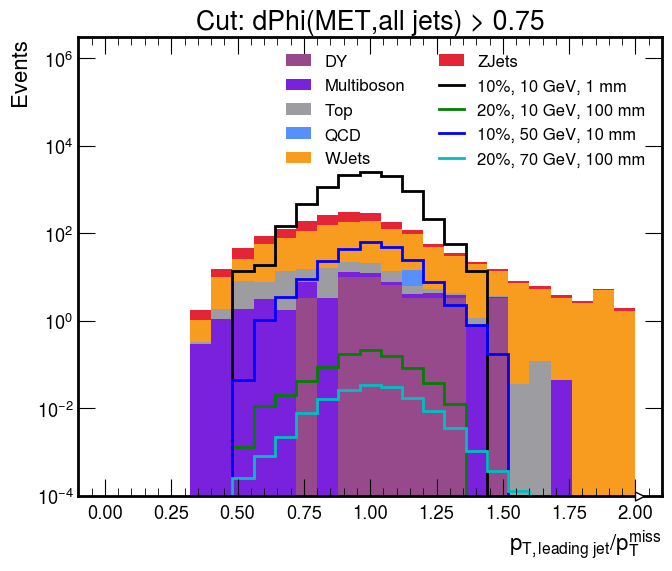

In [40]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "jetMETratio_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$p_{T,\text{leading jet}}/p_T^\mathrm{miss}$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"jetMETratio",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ylim=[1e-4,3e6],ncol_leg=2,xlabel=xlabel,rebin=4j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


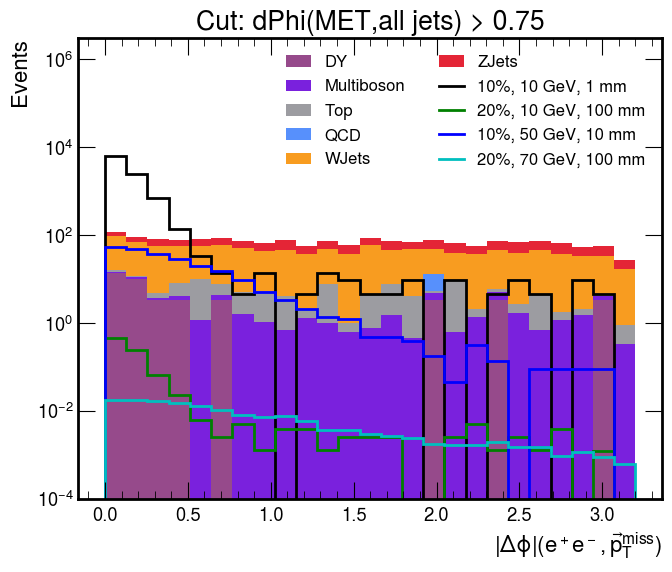

In [43]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_METdPhi_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"$|\Delta\phi|(e^+e^-,\vec{p}_T^\mathrm{miss})$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_METdPhi",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ylim=[1e-4,3e6],ncol_leg=2,xlabel=xlabel,rebin=4j,
                        save=False,show=True,logy=True,density=False,title=title,histtype='step',yerr=False)

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


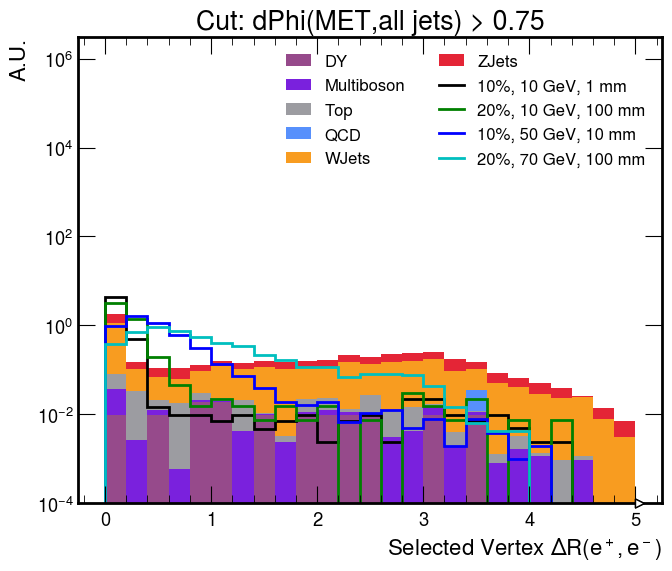

In [45]:
for i,cut in enumerate(cuts):
    CUT = cuts[i]
    outD = f"plots_sigVsBkg/observables/{CUT}"
    outName = "sel_vtx_dR_selectedSignals"+f"_{CUT}"
    selection = {"cut":CUT}
    xlabel = r"Selected Vertex $\Delta R(e^+,e^-)$"
    title = f"Cut: {cutDesc[CUT]}"
    plot_samples_sigBkg(hcs,hcb,"sel_vtx_dR",selection,selected_signals,selected_labels,outName,outD,
                 figsize=(7,6),ylim=[1e-4,3e6],ncol_leg=2,xlabel=xlabel,rebin=4j,
                        save=False,show=True,logy=True,density=True,title=title,histtype='step',yerr=False)

# CDFs

In [46]:
cuts = ['cut4']
cutDesc = hcs.load('cutDesc')

/opt/conda/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


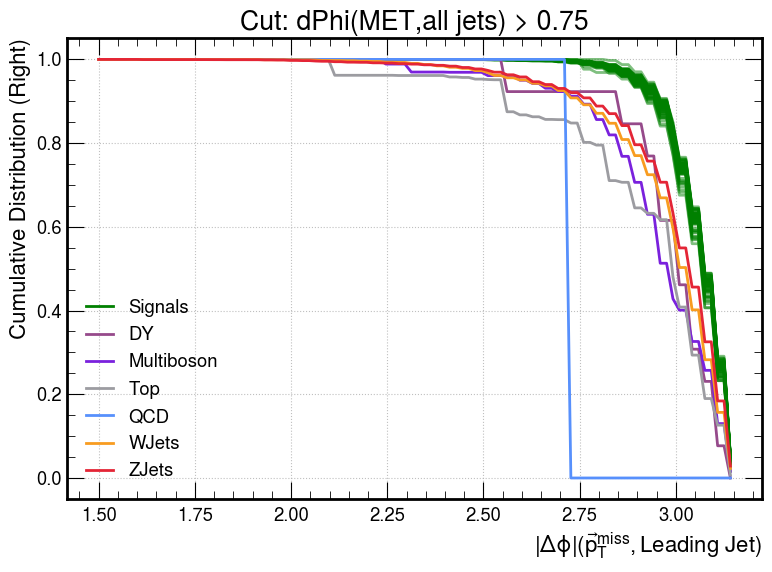

In [47]:
for CUT in cuts:
    selection = {"cut":CUT}
    xlabel = r"$|\Delta\phi|(\vec{p}_T^\mathrm{miss},\text{Leading Jet})$"
    title = f"Cut: {cutDesc[CUT]}"
    hname = "jetMETdPhi"
    outD = f"plots_vtxStudy/cdfs/{CUT}/"
    outName = "cdf_jetMETdPhi"+f"_{CUT}"
    make_cdf_summary_sigVsBkg(dfs,hcs,hcb,hname,hname,selection,outName,outD,xlabel=xlabel,
                              save=False,show=True,right=True,title=title,xlim=[1.5,np.pi])

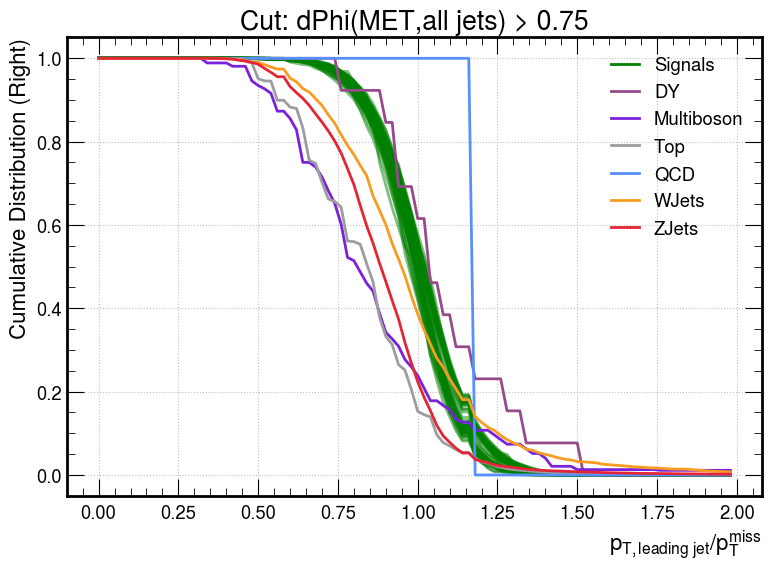

In [49]:
for CUT in cuts:
    selection = {"cut":CUT}
    xlabel = r"$p_{T,\text{leading jet}}/p_T^\mathrm{miss}$"
    title = f"Cut: {cutDesc[CUT]}"
    hname = "jetMETratio"
    outD = f"plots_vtxStudy/cdfs/{CUT}/"
    outName = "cdf_jetMETratio"+f"_{CUT}"
    make_cdf_summary_sigVsBkg(dfs,hcs,hcb,hname,hname,selection,outName,outD,xlabel=xlabel,
                              save=False,show=True,right=True,title=title)

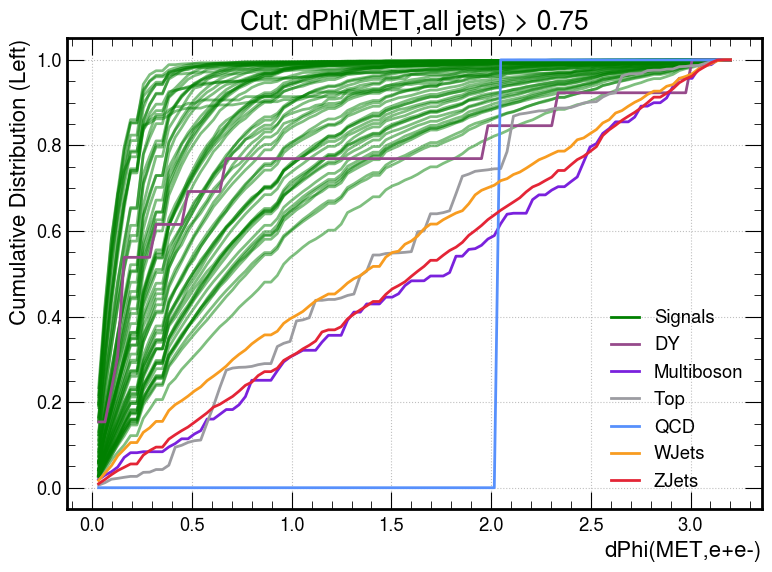

In [53]:
for CUT in cuts:
    selection = {"cut":CUT}
    xlabel = r"dPhi(MET,e+e-)"
    title = f"Cut: {cutDesc[CUT]}"
    hname = "sel_vtx_METdPhi"
    outD = f"plots_vtxStudy/cdfs/{CUT}/"
    outName = "cdf_sel_vtx_METdPhi"+f"_{CUT}"
    make_cdf_summary_sigVsBkg(dfs,hcs,hcb,hname,hname,selection,outName,outD,xlabel=xlabel,
                              save=False,show=True,right=False,title=title)

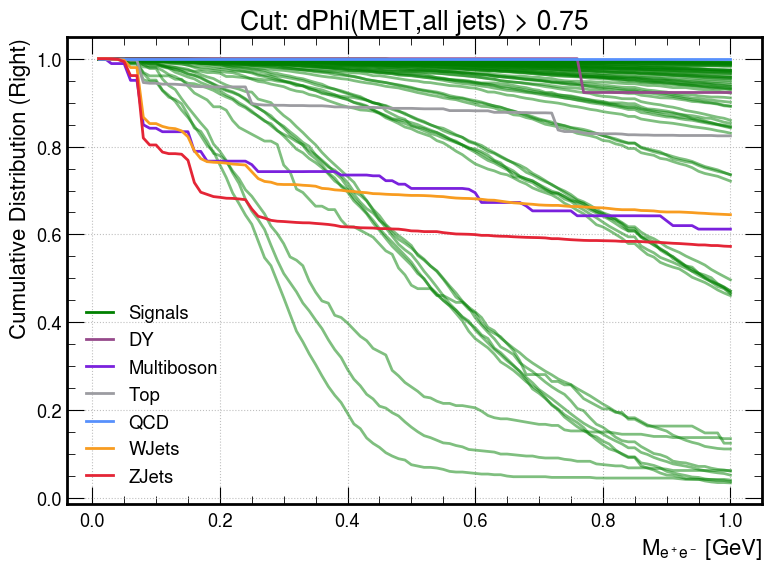

In [55]:
for CUT in cuts:
    selection = {"cut":CUT}
    xlabel = r"$M_{e^+e^-}$ [GeV]"
    title = f"Cut: {cutDesc[CUT]}"
    hname = "sel_vtx_mass_low"
    outD = f"plots_vtxStudy/cdfs/{CUT}/"
    outName = "cdf_sel_vtx_mass_low"+f"_{CUT}"
    make_cdf_summary_sigVsBkg(dfs,hcs,hcb,hname,hname,selection,outName,outD,xlabel=xlabel,
                              save=False,show=True,right=True,title=title,xlim=[0.01,1])

# N-1

In [56]:
cuts = ['cut4']
cutDesc = hcs.load('cutDesc')

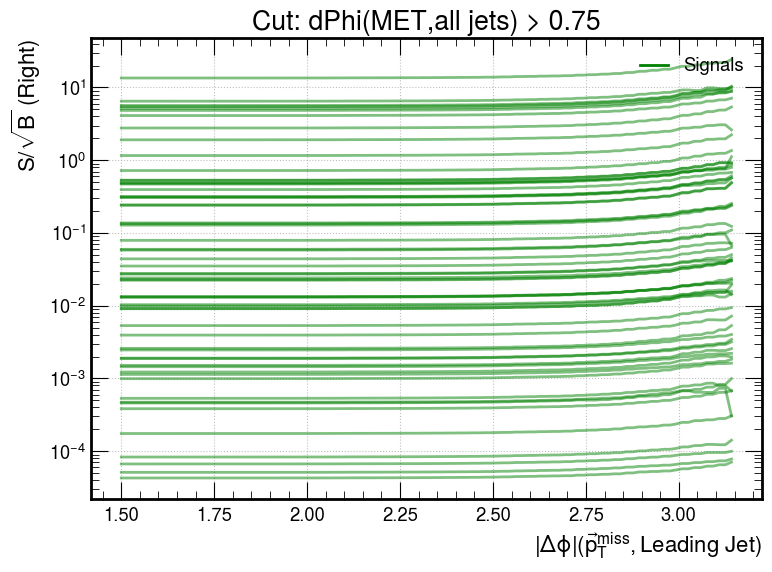

In [57]:
for CUT in cuts:
    selection = {"cut":CUT}
    xlabel = r"$|\Delta\phi|(\vec{p}_T^\mathrm{miss},\text{Leading Jet})$"
    title = f"Cut: {cutDesc[CUT]}"
    hname = "jetMETdPhi"
    outD = f"plots_vtxStudy/cdfs/{CUT}/"
    outName = "Nminus1_allSigs_jetMETdPhi"+f"_{CUT}"
    make_Nminus1_sigVsBkg(dfs,hcs,hcb,hname,hname,selection,outName,outD,xlabel=xlabel,
                              save=False,show=True,right=True,title=title,xlim=[1.5,np.pi],logy=True)

/tmp/ipykernel_737/1627874807.py:33: RuntimeWarning: invalid value encountered in divide
  plt.plot(x,sig_yields/tot_bkg,color='green',alpha=0.5,lw=2)
/tmp/ipykernel_737/1627874807.py:33: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x,sig_yields/tot_bkg,color='green',alpha=0.5,lw=2)


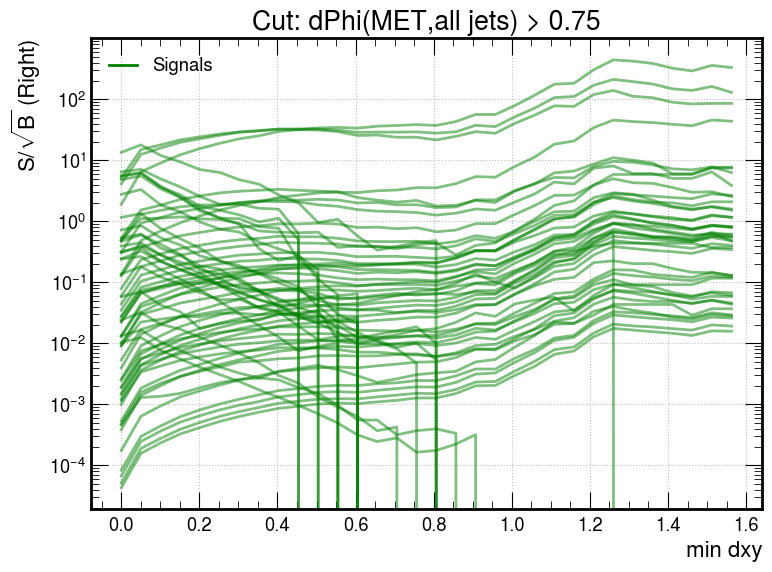

In [59]:
for CUT in cuts:
    selection = {"cut":CUT}
    xlabel = r"min dxy"
    title = f"Cut: {cutDesc[CUT]}"
    hname = "sel_vtx_mindxy"
    outD = f"plots_vtxStudy/cdfs/{CUT}/"
    outName = "Nminus1_allSigs_minDxy"+f"_{CUT}"
    make_Nminus1_sigVsBkg(dfs,hcs,hcb,hname,hname,selection,outName,outD,xlabel=xlabel,
                              save=False,show=True,right=True,title=title,logy=True)

# Cutflows

In [60]:
hcs = histContainer("skimmed_signal_histos_cuts.coffea")
hcs170 = histContainer("skimmed_signal_MET170_histos_cuts.coffea")
hcb = histContainer("skimmed_bkg_histos_cuts.coffea",bkg=True)
hcb170 = histContainer("skimmed_bkg_MET170_histos_cuts.coffea",bkg=True)

In [74]:
cfb = hcb.load("cutflow")
cfb170 = hcb170.load("cutflow")
cfs = hcs.load("cutflow")
cfs170 = hcs170.load("cutflow")

In [72]:
samples = list(cfb.keys())
cuts = list(cfb[samples[0]].keys())
for s in samples:
    print(s)
    for c in cuts:
        print(f"\t {c} {cfb[s][c]:.5e} {cfb170[s][c]:.5e} {cfb170[s][c]/cfb[s][c]}")

bkg_2018_QCD_QCD_HT300to500
	 all 1.74785e-08 8.73923e-08 5.0
	 hasVtx 0.00000e+00 0.00000e+00 nan
	 cut0 0.00000e+00 0.00000e+00 nan
	 cut1 0.00000e+00 0.00000e+00 nan
	 cut2 0.00000e+00 0.00000e+00 nan
	 cut3 0.00000e+00 0.00000e+00 nan
	 cut4 0.00000e+00 0.00000e+00 nan
bkg_2018_WJets_WJetsLNu_HT70to100
	 all 2.61360e-06 9.20984e-06 3.523809523809524
	 hasVtx 0.00000e+00 7.77858e-08 inf
	 cut0 0.00000e+00 7.77858e-08 inf
	 cut1 0.00000e+00 4.66715e-08 inf
	 cut2 0.00000e+00 4.66715e-08 inf
	 cut3 0.00000e+00 4.66715e-08 inf
	 cut4 0.00000e+00 4.66715e-08 inf
bkg_2018_QCD_QCD_HT500to700
	 all 1.49434e-06 3.96326e-06 2.6521739130434785
	 hasVtx 1.62429e-08 6.49715e-08 4.0
	 cut0 1.62429e-08 6.49715e-08 4.0
	 cut1 1.62429e-08 6.49715e-08 4.0
	 cut2 1.62429e-08 6.49715e-08 4.0
	 cut3 1.62429e-08 4.87286e-08 3.0
	 cut4 0.00000e+00 0.00000e+00 nan
bkg_2018_Multiboson_WZZ
	 all 2.05829e-03 2.72034e-03 1.3216494443643745
	 hasVtx 1.27317e-05 1.27317e-05 1.0
	 cut0 1.27317e-05 1.27317e-05 1.

/tmp/ipykernel_737/390451183.py:6: RuntimeWarning: invalid value encountered in double_scalars
  print(f"\t {c} {cfb[s][c]:.5e} {cfb170[s][c]:.5e} {cfb170[s][c]/cfb[s][c]}")
/tmp/ipykernel_737/390451183.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  print(f"\t {c} {cfb[s][c]:.5e} {cfb170[s][c]:.5e} {cfb170[s][c]/cfb[s][c]}")


In [76]:
samples = list(cfs.keys())
cuts = list(cfs[samples[0]].keys())
cuts = ['all','cut4']
for s in samples:
    print(s)
    for c in cuts:
        print(f"\t {c} {cfs[s][c]:.5e} {cfs170[s][c]:.5e} {cfs170[s][c]/cfs[s][c]}")

sig_2018_Mchi-55p0_dMchi-10p0_ctau-1
	 all 2.82715e-02 4.77382e-02 1.6885603777422924
	 cut4 1.08914e-02 1.79575e-02 1.6487830808686432
sig_2018_Mchi-5p5_dMchi-1p0_ctau-100
	 all 1.89054e-03 3.76382e-03 1.9908741736982356
	 cut4 1.94259e-04 4.36051e-04 2.244684631924648
sig_2018_Mchi-5p5_dMchi-1p0_ctau-10
	 all 4.72336e-03 9.61469e-03 2.035559805384628
	 cut4 1.25254e-03 2.58778e-03 2.066022995948707
sig_2018_Mchi-5p25_dMchi-0p5_ctau-1
	 all 7.79785e-03 1.47867e-02 1.896252778595971
	 cut4 1.44164e-03 2.73406e-03 1.8964909886246526
sig_2018_Mchi-5p25_dMchi-0p5_ctau-10
	 all 3.91450e-03 7.54336e-03 1.927026881640436
	 cut4 7.85644e-04 1.51463e-03 1.927883385370292
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10
	 all 2.08715e-02 3.64888e-02 1.7482576629516813
	 cut4 9.18473e-03 1.64276e-02 1.7885714681971896
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100
	 all 9.81228e-03 1.73310e-02 1.7662555989886435
	 cut4 2.83608e-03 5.39024e-03 1.900597372008788
sig_2018_Mchi-105p0_dMchi-10p0_ctau-1
	 all 5.50527e-0